In [1]:
import json
import numpy as np
import pickle
import os
import sys
sys.path.append("/ceph/hpc/data/d2024d05-018-users/wenyan/code/VisU/scripts")

from vector_dataset import FlatFileVectorBlockStore
os.environ["HF_HOME"] = "/ceph/hpc/data/d2024d05-018-users/wenyan/cache"

import matplotlib.pyplot as plt
import numpy as np

In [3]:
import os 
import yaml

def load_config(config_path):
    with open(config_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = load_config("/ceph/hpc/data/d2024d05-018-users/wenyan/code/VisU/scripts/reconstruct_res.yaml")
    

model_name = "llava"
dataset_name = "vizwizgvqa"

pred_dir = os.path.join("/ceph/hpc/data/d2024d05-018-users/wenyan/data/VisU/output/embed_reconstruction_res/pred/",
                        config[dataset_name][model_name]["model_dir"]) # provide here the trained reconstruction model path
pred_vector_folder = os.path.join(pred_dir, "pred_vectors") # path of reconstructed embeddings
gt_vector_folder = os.path.join("/ceph/hpc/data/d2024d05-018-users/wenyan/data/VisU/output/embed/",
                                config[dataset_name][model_name]["gt_vector_dir"]) # provide here the ground truth embeddings path


In [4]:
## load vectors
target_emb_store = FlatFileVectorBlockStore(gt_vector_folder, max_cache_size=100, prefix="pre")
pred_emb_store = FlatFileVectorBlockStore(os.path.join(pred_dir, "pred_vectors"), max_cache_size=100, prefix="pred")
dataset_stats = pickle.load(open(os.path.join(pred_dir, "dataset_stats.pkl"), "rb"))

In [5]:
# load block2imgid (this is generated automatically during embedding extraction step)
block2imgid_file = os.path.join(gt_vector_folder, f"{model_name}_block2imgid.pkl")
print("block2imgid file: ", block2imgid_file)
reconstruct_res_file = f"{pred_dir}/full_evaluation_results.pkl"
reconstruct_res = pickle.load(open(reconstruct_res_file, "rb"))
block2imgid = pickle.load(open(block2imgid_file, "rb"))
block2imgid = {int(k.item()): v for k, v in block2imgid.items()}

block2imgid file:  /ceph/hpc/data/d2024d05-018-users/wenyan/data/VisU/output/embed/llava_vector_blocks_vizwizgvqa/llava_block2imgid.pkl


In [7]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

def visualize_patch_differences_l2norm_signed(img_id, image_pixels, original_embeddings, predicted_embeddings,
                                              processor, patch_size=14, image_size=336, top_k=10):
    """
    Generates 3 PDFs with identical dimensions suitable for side-by-side placement,
    avoiding tight_layout for individual plots for maximum consistency, and hiding
    all axis ticks on the main plot areas.
    """
    # --- Font Setup ---
    try:
        # Set default font family to serif
        matplotlib.rcParams['font.family'] = 'serif'
        # Prioritize Times New Roman within the serif family
        matplotlib.rcParams['font.serif'] = ['Times New Roman'] + matplotlib.rcParams['font.serif']
        # Check if font was actually found (optional, requires font_manager)
        # import matplotlib.font_manager as fm
        # fm.findfont("Times New Roman", fallback_to_default=False)
        print("Using Times New Roman font.")
    except ValueError:
        print("Times New Roman not found, using default serif font.")
        # Keep serif as the fallback if Times New Roman isn't available
        matplotlib.rcParams['font.family'] = 'serif'

    # --- Constants and Calculations ---
    num_patches = image_size // patch_size
    num_patches_total = num_patches * num_patches
    CBAR_LABEL_FONTSIZE = 24 # Font size for colorbar label
    CBAR_TICK_FONTSIZE = 21  # Font size for colorbar tick labels
    # Figure dimensions (inches) - adjust if elements get clipped
    FIG_WIDTH = 11.5
    FIG_HEIGHT = 10
    # Colorbar width as a percentage of the main axes width
    CBAR_WIDTH = "5%"
    # Padding between the main axes and the colorbar
    CBAR_PAD = 0.2

    # --- Image Denormalization ---
    # Transpose image dimensions for plotting (C, H, W) -> (H, W, C)
    img = image_pixels.transpose(1, 2, 0)
    # Get mean and std from the processor for denormalization
    mean = np.array(processor.image_processor.image_mean)
    std = np.array(processor.image_processor.image_std)
    # Denormalize: (pixel * std) + mean
    img = img * std + mean
    # Clip values to [0, 1] range (necessary if values went slightly out of bounds)
    # then scale to [0, 255] and convert to unsigned 8-bit integer for image display
    img = np.clip(img * 255, 0, 255).astype(np.uint8)

    # --- Embedding Norm Calculation ---
    # Calculate L2 norm (Euclidean distance from origin) for each original embedding vector
    original_norms = np.linalg.norm(original_embeddings, axis=1)
    # Calculate L2 norm for each predicted embedding vector
    predicted_norms = np.linalg.norm(predicted_embeddings, axis=1)
    # Calculate the signed difference: original norm - predicted norm
    norm_differences = original_norms - predicted_norms
    # Reshape the 1D difference array into a 2D grid matching the patch layout
    diff_matrix = norm_differences.reshape(num_patches, num_patches)
    # Find the maximum absolute difference for symmetric color scaling
    max_abs_diff = max(abs(diff_matrix.min()), abs(diff_matrix.max())) if len(diff_matrix) > 0 else 1.0
    # Avoid division by zero if all differences are zero
    if max_abs_diff == 0: max_abs_diff = 1.0
    # Normalize the difference matrix to [-1, 1] for the overlay heatmap
    diff_normalized = diff_matrix / max_abs_diff
    # Create a full-resolution heatmap for overlay by repeating patch values
    heatmap_full = np.repeat(np.repeat(diff_normalized, patch_size, axis=0), patch_size, axis=1)

    # --- Top K Calculation ---
    # Calculate absolute differences to find the largest magnitudes
    abs_differences = np.abs(norm_differences)
    # Determine how many patches to highlight (cannot exceed total number of patches)
    actual_top_k = min(top_k, num_patches_total)
    if actual_top_k > 0:
        # Find the indices of the top_k largest absolute differences
        flat_indices = np.argsort(abs_differences)[-actual_top_k:]
        # Convert the flat indices back to 2D (row, column) indices
        row_indices, col_indices = np.unravel_index(flat_indices, (num_patches, num_patches))
    else:
        # Handle the case where top_k is 0 or there are no patches
        flat_indices, row_indices, col_indices = [], [], []


    # --- Create and save each subplot separately ---
    # --- Save WITHOUT tight_layout and WITHOUT bbox_inches='tight' ---
    # This ensures identical canvas sizes for all saved PDFs.

    # 1. Original image with grid
    fig1 = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    # Define axes position explicitly [left, bottom, width, height] as fractions
    # Calculate width needed for the main axis to leave room for colorbar area
    ax_width_fraction = 1.0 / (1.0 + float(CBAR_WIDTH.strip('%'))/100.0 + CBAR_PAD*2)
    # Define axis position (adjust margins if needed)
    ax1_pos = [0.05, 0.05, ax_width_fraction * 0.85, 0.9]
    ax1 = fig1.add_axes(ax1_pos)
    # Set aspect ratio to equal and adjust the axes box size to fit
    ax1.set_aspect('equal', adjustable='box')

    # Display the denormalized image
    im1 = ax1.imshow(img)
    # Draw red grid lines corresponding to patches
    for i in range(0, image_size, patch_size):
        ax1.axhline(y=i, color='r', linestyle='-', alpha=0.3)
        ax1.axvline(x=i, color='r', linestyle='-', alpha=0.3)
    # Remove axis ticks and labels
    ax1.set_xticks([])
    ax1.set_yticks([])

    # Create a divider linked to the main axis
    divider1 = make_axes_locatable(ax1)
    # Append an axis for the colorbar space to the right
    cax1 = divider1.append_axes("right", size=CBAR_WIDTH, pad=CBAR_PAD)
    # Make this placeholder colorbar axis invisible
    cax1.axis('off')

    # Save the figure using the defined figsize, without tight_layout or bbox_inches
    img_id_prefix = img_id.strip(".jpg")
    plt.savefig(f"{img_id_prefix}_original.pdf", dpi=500)
    print("Saved subplot_1_original.pdf")
    plt.close(fig1) # Close figure to free memory


    # 2. Heatmap of differences
    fig2 = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    # Use the same axes bounds as fig1 for consistency
    ax2 = fig2.add_axes(ax1_pos) # Use ax1_pos calculated earlier
    ax2.set_aspect('equal', adjustable='box')

    # Display the heatmap of signed differences
    heatmap = ax2.imshow(diff_matrix, cmap='RdBu', clim=(-max_abs_diff, max_abs_diff),
                         extent=[0, image_size, image_size, 0], origin='upper')
    # Define minor ticks for the grid lines
    ax2.set_xticks(np.arange(0, image_size+1, patch_size), minor=True)
    ax2.set_yticks(np.arange(0, image_size+1, patch_size), minor=True)
    # Draw the grid using the minor tick locations
    ax2.grid(True, which='minor', color='white', linewidth=0.5, alpha=0.3)

    # Add yellow boxes and numbers for the top K patches
    for i in range(actual_top_k):
        # Get row and column for the i-th highest difference patch
        idx = -1 - i # Iterate from largest diff index downwards
        row, col = row_indices[idx], col_indices[idx]
        # Draw rectangle
        rect2 = patches.Rectangle((col * patch_size, row * patch_size), patch_size, patch_size,
                                linewidth=2, edgecolor='yellow', facecolor='none')
        ax2.add_patch(rect2)
        # Add rank number (1 = largest difference)
        ax2.text(col * patch_size + patch_size/2, row * patch_size + patch_size/2,
                 str(i+1), color='yellow', fontweight='bold', ha='center', va='center', fontsize=16)

    # Remove MAJOR axis ticks and labels
    ax2.set_xticks([])
    ax2.set_yticks([])
    # Remove MINOR axis tick MARKS (the small lines) while keeping their positions for the grid
    ax2.tick_params(axis='both', which='minor', length=0)

    # Create divider linked to the main axis
    divider2 = make_axes_locatable(ax2)
    # Append axis for the actual colorbar
    cax2 = divider2.append_axes("right", size=CBAR_WIDTH, pad=CBAR_PAD)
    # Add the colorbar to the dedicated axis 'cax2'
    cbar2 = fig2.colorbar(heatmap, cax=cax2)
    # Set colorbar label and font sizes
    cbar2.set_label('Embedding Norm Difference', fontsize=CBAR_LABEL_FONTSIZE)
    cbar2.ax.tick_params(labelsize=CBAR_TICK_FONTSIZE)

    # Save the figure
    plt.savefig(f"{img_id_prefix}_heatmap.pdf", dpi=500)
    print("Saved subplot_2_heatmap.pdf")
    plt.close(fig2)


    # 3. Overlay visualization
    fig3 = plt.figure(figsize=(FIG_WIDTH, FIG_HEIGHT))
    # Use the same axes bounds as fig1/fig2
    ax3 = fig3.add_axes(ax1_pos) # Use ax1_pos calculated earlier
    ax3.set_aspect('equal', adjustable='box')

    # Display the original image first
    ax3.imshow(img)
    # Overlay the normalized heatmap with transparency
    overlay = ax3.imshow(heatmap_full, cmap='RdBu', alpha=0.5, clim=(-1, 1),
                         extent=[0, image_size, image_size, 0], origin='upper')
    # Draw red grid lines on top
    for i in range(0, image_size, patch_size):
        ax3.axhline(y=i, color='r', linestyle='-', alpha=0.3)
        ax3.axvline(x=i, color='r', linestyle='-', alpha=0.3)

    # Add yellow boxes and numbers for the top K patches
    for i in range(actual_top_k):
        idx = -1 - i # Iterate from largest diff index downwards
        row, col = row_indices[idx], col_indices[idx]
        # Draw rectangle
        rect3 = patches.Rectangle((col * patch_size, row * patch_size), patch_size, patch_size,
                                linewidth=2, edgecolor='yellow', facecolor='none')
        ax3.add_patch(rect3)
        # Add rank number
        ax3.text(col * patch_size + patch_size/2, row * patch_size + patch_size/2,
                 str(i+1), color='yellow', fontweight='bold', ha='center', va='center', fontsize=16)

    # Remove axis ticks and labels
    ax3.set_xticks([])
    ax3.set_yticks([])

    # Create divider linked to the main axis
    divider3 = make_axes_locatable(ax3)
    # Append axis for the colorbar
    cax3 = divider3.append_axes("right", size=CBAR_WIDTH, pad=CBAR_PAD)
    # Add the colorbar for the overlay image
    cbar3 = fig3.colorbar(overlay, cax=cax3)
    # Set colorbar label and font sizes
    cbar3.set_label('Normalized Difference', fontsize=CBAR_LABEL_FONTSIZE)
    cbar3.ax.tick_params(labelsize=CBAR_TICK_FONTSIZE)

    # Save the figure
    plt.savefig(f"{img_id_prefix}_overlay.pdf", dpi=500)
    print("Saved subplot_3_overlay.pdf")
    plt.close(fig3)


    # --- Combined figure (Optional) ---
    # This uses standard subplots and layout management which might differ slightly
    # from the individually saved plots. Keep tight_layout and bbox_inches here if desired.
    fig_comb, (ax_c1, ax_c2, ax_c3) = plt.subplots(1, 3, figsize=(24, 8)) # Adjust figsize as needed

    # Plot original image on ax_c1
    ax_c1.imshow(img)
    for i in range(0, image_size, patch_size):
        ax_c1.axhline(y=i, color='r', linestyle='-', alpha=0.3)
        ax_c1.axvline(x=i, color='r', linestyle='-', alpha=0.3)

    # Plot heatmap of signed differences on ax_c2
    heatmap_comb = ax_c2.imshow(diff_matrix, cmap='RdBu', clim=(-max_abs_diff, max_abs_diff),
                                extent=[0, image_size, image_size, 0], origin='upper')
    # Add colorbar directly linked to ax_c2
    cbar1_comb = plt.colorbar(heatmap_comb, ax=ax_c2, fraction=0.046, pad=0.04) # Adjust fraction/pad
    cbar1_comb.set_label('Embedding Norm Difference', fontsize=CBAR_LABEL_FONTSIZE)
    cbar1_comb.ax.tick_params(labelsize=CBAR_TICK_FONTSIZE)
    # Add grid lines for combined plot ax_c2
    ax_c2.set_xticks(np.arange(0, image_size+1, patch_size), minor=True)
    ax_c2.set_yticks(np.arange(0, image_size+1, patch_size), minor=True)
    ax_c2.grid(True, which='minor', color='white', linewidth=0.5, alpha=0.3)
    ax_c2.tick_params(axis='both', which='minor', length=0) # Hide minor ticks here too

    # Create overlay visualization on ax_c3
    ax_c3.imshow(img)
    overlay_comb = ax_c3.imshow(heatmap_full, cmap='RdBu', alpha=0.5, clim=(-1, 1),
                                extent=[0, image_size, image_size, 0], origin='upper')
    # Add colorbar directly linked to ax_c3
    cbar2_comb = plt.colorbar(overlay_comb, ax=ax_c3, fraction=0.046, pad=0.04) # Adjust fraction/pad
    cbar2_comb.set_label('Normalized Difference', fontsize=CBAR_LABEL_FONTSIZE)
    cbar2_comb.ax.tick_params(labelsize=CBAR_TICK_FONTSIZE)
    # Add grid lines for combined plot ax_c3
    for i in range(0, image_size, patch_size):
        ax_c3.axhline(y=i, color='r', linestyle='-', alpha=0.3)
        ax_c3.axvline(x=i, color='r', linestyle='-', alpha=0.3)

    # Add rectangles and numbers to combined heatmap and overlay
    for i in range(actual_top_k):
        idx = -1 - i
        row, col = row_indices[idx], col_indices[idx]
        # Box for ax_c2
        rect_c2 = patches.Rectangle((col * patch_size, row * patch_size), patch_size, patch_size,
                                   linewidth=2, edgecolor='yellow', facecolor='none')
        ax_c2.add_patch(rect_c2)
        ax_c2.text(col * patch_size + patch_size/2, row * patch_size + patch_size/2,
                   str(i+1), color='yellow', fontweight='bold', ha='center', va='center', fontsize=16)
        # Box for ax_c3
        rect_c3 = patches.Rectangle((col * patch_size, row * patch_size), patch_size, patch_size,
                                   linewidth=2, edgecolor='yellow', facecolor='none')
        ax_c3.add_patch(rect_c3)
        ax_c3.text(col * patch_size + patch_size/2, row * patch_size + patch_size/2,
                   str(i+1), color='yellow', fontweight='bold', ha='center', va='center', fontsize=16)

    # Common settings for combined plot axes
    for ax in [ax_c1, ax_c2, ax_c3]:
        ax.set_aspect('equal') # Maintain aspect ratio
        ax.set_xticks([])      # Remove major ticks/labels
        ax.set_yticks([])

    # Use tight_layout for the combined figure arrangement
    plt.tight_layout()
    # Save combined figure, bbox_inches='tight' is generally useful here
    plt.savefig("patch_diff_combined.pdf", bbox_inches='tight', dpi=500)
    print("Saved patch_diff_combined.pdf")
    plt.show() # Display the combined plot


    # --- Print diagnostic information ---
    print("\nEmbedding norm difference stats:")
    if num_patches_total > 0:
        print(f"Min difference: {norm_differences.min():.3f}")
        print(f"Max difference: {norm_differences.max():.3f}")
        print(f"Mean difference: {norm_differences.mean():.3f}")
        print(f"Std difference: {norm_differences.std():.3f}")

        print(f"\nTop {actual_top_k} largest absolute differences at positions (ranked 1=largest):")
        # Sort indices by descending absolute difference for printing rank correctly
        sorted_flat_indices = np.argsort(abs_differences)[::-1][:actual_top_k]
        for rank, pos_idx in enumerate(sorted_flat_indices):
             row, col = np.unravel_index(pos_idx, (num_patches, num_patches))
             print(f"#{rank+1} - Position ({row}, {col}): {norm_differences[pos_idx]:.3f} " +
                   f"(Orig norm: {original_norms[pos_idx]:.3f}, Pred norm: {predicted_norms[pos_idx]:.3f})")
    else:
        print("No patches to analyze.")


    return diff_normalized # Return the normalized difference matrix


## Norm visualization

In [8]:
from transformers.image_utils import load_image

def get_embed_change_visualizaiton(img_id, processor, image, original_embeddings, predicted_embeddings, patch_size=14, image_size=336, top_k=10):
    if isinstance(image, str):
        image = load_image(image)
    

    pixel_values = processor.image_processor(images=[image], 
                                        size={"longest_edge": 336, "shortest_edge": 336},return_tensors="pt").pixel_values
    
    diff_matrix = visualize_patch_differences_l2norm_signed(img_id, pixel_values.squeeze().cpu().numpy(), original_embeddings, predicted_embeddings, 
                                              processor, patch_size, image_size, top_k)
    
    return diff_matrix

/ceph/hpc/home/euwenyanl/miniconda3/envs/visu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def get_vizwiz_image_path(image_id, data_config):
    image_path = os.path.join(data_config["datasets"]["vizwizgvqa"]['image_dir'], image_id)
    return image_path

def get_coco_caption_image_path(image_id, data_config):
    image_path = os.path.join(data_config["datasets"]["coco_test"]['image_dir'], image_id)
    return image_path

Load image processor

In [15]:
import sys
from transformers.image_utils import load_image
from transformers import AutoProcessor
import utils

if model_name == "idefics2":
    processor, model = utils.load_idefics2()
elif model_name == "llava":
    processor, model = utils.load_llava()
elif model_name == "qwen":
    processor, model = utils.load_qwenvl()
else:
    print("Model not supported")

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 
Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  2.40it/s]
Some parameters are on the meta device because they were offloaded to the cpu.


In [16]:
from reconstruct_embeddings_parallel import standardize_embeddings
def get_normalized(target_emb, dataset_stats):
    return standardize_embeddings(target_emb, dataset_stats["mean_pre"], dataset_stats["std_pre"]).cpu().numpy()

In [17]:
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import json
import re

def process_answer(answer):
    """Process an answer similar to VQA evaluation"""
    answer = answer.lower()
    answer = re.sub(r'\s+', ' ', answer).strip()
    answer = answer.replace(',', '')
    answer = answer.replace('/', ' ')
    if answer.isdigit():
        answer = str(int(answer))  # Remove leading zeros
    return answer.strip(".").strip()

def compute_vqa_accuracy(pred_answer, gt_answers):
    """
    Compute VQA accuracy using the official metric:
    min(# of humans that said pred_answer / 3, 1)
    """
    pred_answer = process_answer(pred_answer)
    gt_answers = [process_answer(ans) for ans in gt_answers]
    
    # Count how many times the predicted answer matches the ground truth
    match_count = sum(1 for gt in gt_answers if pred_answer == gt)
    
    # Calculate accuracy according to VQA metric
    accuracy = min(match_count / 3.0, 1.0)
    return accuracy

def visualize_vqa_with_ground_truth(data_list, image_ids, idx, annotation_path):
    """
    Visualize VQA data with ground truth annotations for a given image_id
    
    Parameters:
    data_list (list): List of dictionaries containing VQA data
    image_id (int): ID of the image to visualize
    annotation_path (str): Path to the annotation JSON file
    """
    image_id = image_ids[idx]
    # Load ground truth annotations
    with open(annotation_path, 'r') as f:
        annotations = json.load(f)
    
    # Create a dictionary mapping question_id to ground truth answers
    gt_answers = {}
    for ann in annotations['annotations']:
        if ann['image_id'] == image_id:
            gt_answers[ann['question_id']] = [ans['answer'] for ans in ann['answers']]
    
    # Filter data for the given image_id
    image_data = [item for item in data_list if item['image_id'] == image_id]
    
    if not image_data:
        print(f"No data found for image_id: {image_id}")
        return
    
    # Create a figure with two areas: one for the image and one for the Q&A table
    plt.figure(figsize=(20, 10))
    
    # Plot image on the left
    plt.subplot(1, 2, 1)
    try:
        img = Image.open(image_data[0]['image'])
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image ID: {image_id}")
    except Exception as e:
        plt.text(0.5, 0.5, f"Error loading image:\n{str(e)}", 
                ha='center', va='center')
    
    # Create Q&A table with ground truth on the right
    plt.subplot(1, 2, 2)
    
    # Prepare data for the table
    table_data = []
    for d in image_data:
        gt = gt_answers.get(d['question_id'], ['N/A'])
        # Format ground truth answers as a string
        gt_str = '\n'.join([f"{i+1}. {ans}" for i, ans in enumerate(gt)])
        table_data.append([
            d['question'],
            d['response'],
            gt_str
        ])
    
    df = pd.DataFrame(table_data, columns=['Question', 'Model Answer', 'Ground Truth Answers'])
    
    # Hide axes
    plt.axis('off')
    
    # Create table
    table = plt.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='left',
                     loc='center',
                     bbox=[0, 0, 1, 1])
    
    # Adjust table properties
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    
    # Set column widths
    col_widths = [0.4, 0.3, 0.3]
    for i in range(len(df.columns)):
        for j in range(len(df) + 1):
            cell = table._cells[(j, i)]
            cell.set_width(col_widths[i])
            cell.set_height(0.1)
            # Enable text wrapping
            cell._text.set_wrap(True)
    
    plt.tight_layout()
    plt.show()

    # Print accuracy metrics using VQA v2 accuracy calculation
    print("\nAccuracy Metrics:")
    accuracies = []
    for d in image_data:
        gt = gt_answers.get(d['question_id'], ['N/A'])
        if gt != ['N/A']:
            accuracy = compute_vqa_accuracy(d['response'], gt)
            accuracies.append(accuracy)
    
    if accuracies:
        mean_accuracy = sum(accuracies) / len(accuracies)
        print(f"Number of questions: {len(accuracies)}")
        print(f"Mean VQA Accuracy: {mean_accuracy:.3f}")
        print(f"Mean VQA Accuracy (%): {mean_accuracy * 100:.2f}%")

In [18]:
# read pred 
def read_jsonl(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    return data


In [26]:
data_config = load_config("/ceph/hpc/data/d2024d05-018-users/wenyan/code/VisU/datasets.yaml")
all_pred = read_jsonl(f"/ceph/hpc/data/d2024d05-018-users/wenyan/data/VisU/output/vqa/{model_name}_vizwizgvqa_res/{model_name}_vizwizgvqa_pred_val.jsonl")
vizwiz_ann = json.load(open(data_config["datasets"]["vizwizgvqa"]["ann_path"], "r"))

all_pred_dict = {pred["question_id"]: pred for pred in all_pred}
all_accuracies = {}
for img_id in all_pred_dict.keys():
    accuracy = compute_vqa_accuracy(all_pred_dict[img_id]["response"], vizwiz_ann[img_id]["answers"])
    all_accuracies[img_id] = accuracy

image_id: VizWiz_val_00003594.jpg
 question: What is this a can of?
 answers: ['campbells soup', 'soup', 'unsuitable', 'unanswerable', 'soup', 'soup', 'soup', 'soup', 'chicken rice soup', 'unable to see full label something rice please take photo from side']
 pred: rice
Using Times New Roman font.
Saved subplot_1_original.pdf
Saved subplot_2_heatmap.pdf
Saved subplot_3_overlay.pdf
Saved patch_diff_combined.pdf


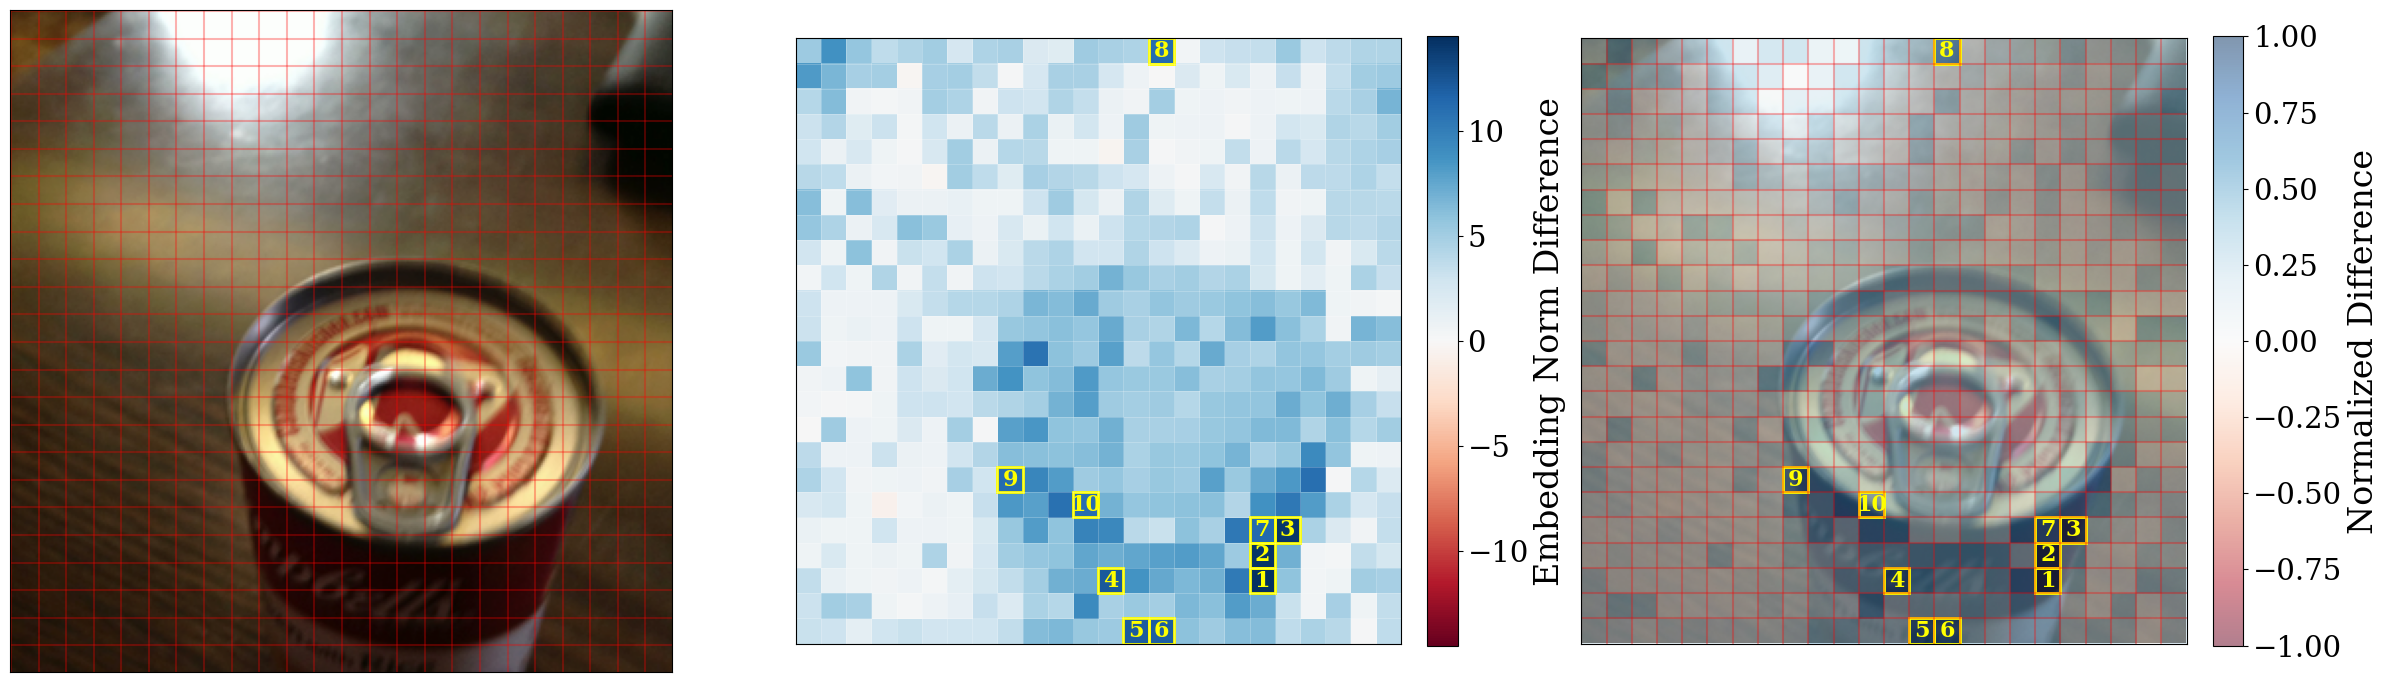


Embedding norm difference stats:
Min difference: -0.665
Max difference: 14.526
Mean difference: 3.811
Std difference: 2.684

Top 10 largest absolute differences at positions (ranked 1=largest):
#1 - Position (21, 18): 14.526 (Orig norm: 47.901, Pred norm: 33.375)
#2 - Position (20, 18): 14.234 (Orig norm: 47.203, Pred norm: 32.969)
#3 - Position (19, 19): 14.079 (Orig norm: 47.079, Pred norm: 33.000)
#4 - Position (21, 12): 12.240 (Orig norm: 40.881, Pred norm: 28.641)
#5 - Position (23, 13): 12.096 (Orig norm: 42.221, Pred norm: 30.125)
#6 - Position (23, 14): 12.013 (Orig norm: 41.981, Pred norm: 29.969)
#7 - Position (19, 18): 11.304 (Orig norm: 42.898, Pred norm: 31.594)
#8 - Position (0, 14): 11.167 (Orig norm: 41.276, Pred norm: 30.109)
#9 - Position (17, 8): 11.127 (Orig norm: 43.627, Pred norm: 32.500)
#10 - Position (18, 11): 11.092 (Orig norm: 41.686, Pred norm: 30.594)


In [27]:
img2blockid = {v: k for k, v in block2imgid.items()}
img_id = "VizWiz_val_00003594.jpg"
idx = img2blockid[img_id]
question, answers, pred = vizwiz_ann[img_id]["question"], vizwiz_ann[img_id]["answers"], all_pred_dict[img_id]["response"].lower()
print(f"image_id: {img_id}\n question: {question}\n answers: {answers}\n pred: {pred}")
diff_matrix = get_embed_change_visualizaiton(img_id, processor, 
                               image=get_vizwiz_image_path(img_id, data_config),
                               original_embeddings=get_normalized(target_emb_store.load(idx), dataset_stats),
                               predicted_embeddings=pred_emb_store.load(idx).cpu().numpy(), 
                               patch_size=14, image_size=336, top_k=10)

### get mask

In [30]:
mask_dir = "/ceph/hpc/data/d2024d05-018-users/wenyan/data/viswiz_vqa_grounding/binary_masks/val" # provide path of binary masks (from the dataset, download from https://vizwiz.org/tasks-and-datasets/answer-grounding-for-vqa/)

In [31]:
from PIL import Image
import numpy as np

def overlay_mask(image_path, mask_path, alpha=0.5, color=(255, 0, 0)):  # color in RGB
    # Open images
    image = Image.open(image_path)
    mask = Image.open(mask_path)
    
    # Convert images to same size if they're different
    mask = mask.resize(image.size)
    
    # Convert mask to grayscale if it's not
    if mask.mode != 'L':
        mask = mask.convert('L')
    
    # Convert images to numpy arrays
    image_arr = np.array(image)
    mask_arr = np.array(mask)
    
    # Create colored mask
    colored_mask = np.zeros_like(image_arr)
    # Broadcast the color to all True pixels
    colored_mask[mask_arr > 0] = np.array(color)[None, None, :]
    
    # Convert back to PIL images
    colored_mask = Image.fromarray(colored_mask.astype(np.uint8))
    
    # Blend images
    overlay = Image.blend(image, colored_mask, alpha)
    return overlay

def get_mask_indices(mask_path, image_size=336, patch_size=14):
    
    # Load and process mask using the same processor
    mask_image = Image.open(mask_path)
    if mask_image.mode != 'L':
        mask_image = mask_image.convert('L')
    
    # Process mask using same processor settings
    processed_mask = processor.image_processor(images=[mask_image], 
                                            size={"longest_edge": 336, "shortest_edge": 336},
                                            return_tensors="pt").pixel_values
    
    # Convert processed mask to binary mask
    mask = processed_mask[0, 0]  # Take first channel only
    mask = (mask > 0.5).numpy().astype(np.uint8)  # Convert to binary mask

    num_patches = image_size // patch_size
    # Create patch-level mask by averaging the mask values in each patch
    patch_mask = np.zeros((num_patches, num_patches))
    masked_indices = []
    
    for i in range(num_patches):
        for j in range(num_patches):
            patch = mask[i*patch_size:(i+1)*patch_size, 
                        j*patch_size:(j+1)*patch_size]
            is_masked = np.any(patch)
            patch_mask[i, j] = is_masked
            if is_masked:
                masked_indices.append(i * num_patches + j)
    return masked_indices

Using Times New Roman font.
Saved subplot_1_original.pdf
Saved subplot_2_heatmap.pdf
Saved subplot_3_overlay.pdf
Saved patch_diff_combined.pdf


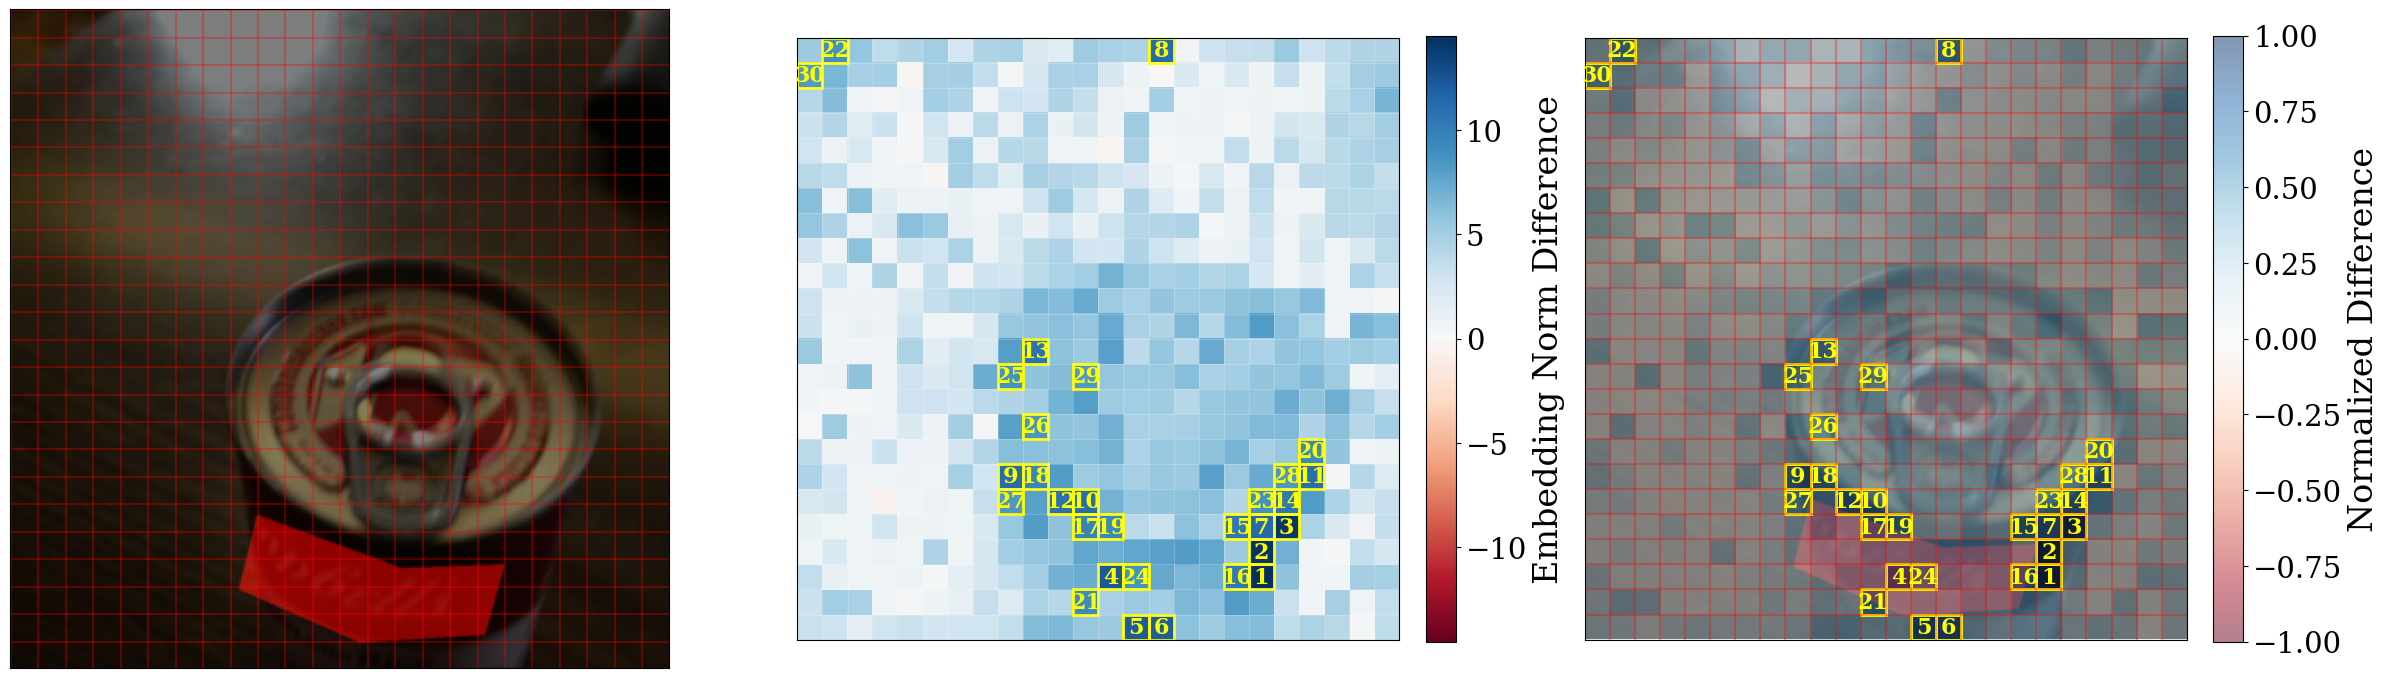


Embedding norm difference stats:
Min difference: -0.665
Max difference: 14.526
Mean difference: 3.811
Std difference: 2.684

Top 30 largest absolute differences at positions (ranked 1=largest):
#1 - Position (21, 18): 14.526 (Orig norm: 47.901, Pred norm: 33.375)
#2 - Position (20, 18): 14.234 (Orig norm: 47.203, Pred norm: 32.969)
#3 - Position (19, 19): 14.079 (Orig norm: 47.079, Pred norm: 33.000)
#4 - Position (21, 12): 12.240 (Orig norm: 40.881, Pred norm: 28.641)
#5 - Position (23, 13): 12.096 (Orig norm: 42.221, Pred norm: 30.125)
#6 - Position (23, 14): 12.013 (Orig norm: 41.981, Pred norm: 29.969)
#7 - Position (19, 18): 11.304 (Orig norm: 42.898, Pred norm: 31.594)
#8 - Position (0, 14): 11.167 (Orig norm: 41.276, Pred norm: 30.109)
#9 - Position (17, 8): 11.127 (Orig norm: 43.627, Pred norm: 32.500)
#10 - Position (18, 11): 11.092 (Orig norm: 41.686, Pred norm: 30.594)
#11 - Position (17, 20): 10.905 (Orig norm: 41.467, Pred norm: 30.562)
#12 - Position (18, 10): 10.876 (Or

In [32]:
# Usage example
def get_mask_overlay(img_id, data_config, mask_dir):
    image_path = get_vizwiz_image_path(img_id, data_config)

    mask_path = os.path.join(mask_dir, img_id.split(".")[0]+".png")
    overlay = overlay_mask(image_path, mask_path, alpha=0.5, color=(255, 0, 0))
    masked_indices = get_mask_indices(mask_path)
    # overlay.show()
    return overlay, masked_indices

overlay, masked_indices = get_mask_overlay(img_id, data_config, mask_dir)
diff_matrix = get_embed_change_visualizaiton(img_id, processor, 
                               image=overlay,
                               original_embeddings=get_normalized(target_emb_store.load(idx), dataset_stats),
                               predicted_embeddings=pred_emb_store.load(idx).cpu().numpy(), 
                               patch_size=14, image_size=336, top_k=30)
print("maksed indices: ", masked_indices)